#  Applied Machine Learning - Evaluation metrics


## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score, 
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


<br><br>

## Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 2 | 8 |
| **Actual no disease**       | 0 | 100 |


- Model B

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 6 | 4 |
| **Actual no disease**       | 10 | 90 |

### Positive vs. negative class 

**tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

In [2]:
# MODEL A 
print("MODEL A :")

TP, FP, FN, TN = 2, 0, 8, 100
precision_A = TP/(TP+FP)
print(f"The precision value is {precision_A}")

recall_A = TP/(TP+FN)
print(f"The precision value is {recall_A}")

f1_score_A = 2*(precision_A*recall_A)/(precision_A+recall_A)
print(f"The precision value is {f1_score_A}")

print()
print("MODEL B :")

TP, FP, FN, TN = 6, 10, 4, 90
precision_B = TP/(TP+FP)
print(f"The precision value is {precision_B}")

recall_B = TP/(TP+FN)
print(f"The precision value is {recall_B}")

f1_score_B = 2*(precision_B*recall_B)/(precision_B+recall_B)
print(f"The precision value is {f1_score_B}")


MODEL A :
The precision value is 1.0
The precision value is 0.2
The precision value is 0.33333333333333337

MODEL B :
The precision value is 0.375
The precision value is 0.6
The precision value is 0.4615384615384615


<br><br>

### Accuracy

**tasks:**

Calculate accuracies for Model A and Model B. 

I'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [3]:
results_dict = {"A": {}, "B": {}}

In [4]:
results_dict["A"]["accuracy"] = 102/110
results_dict["B"]["accuracy"] = 96/110



In [5]:
assert tests_hw5.ex1_2_1(
    results_dict["A"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [6]:
assert tests_hw5.ex1_2_2(
    results_dict["B"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [7]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727


<br><br>

### Which model would you pick? 

**tasks:**

Which model would you pick simply based on the accuracy metric? 

### Precision, recall, f1-score

**tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [8]:
results_dict["A"]["precision"] = precision_A
results_dict["B"]["precision"] = precision_B
results_dict["A"]["recall"] = recall_A
results_dict["B"]["recall"] = recall_B
results_dict["A"]["f1"] = f1_score_A
results_dict["B"]["f1"] = f1_score_B

In [9]:
assert tests_hw5.ex1_4_1(
    results_dict["A"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [10]:
assert tests_hw5.ex1_4_2(
    results_dict["B"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [11]:
assert tests_hw5.ex1_4_3(
    results_dict["A"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [12]:
assert tests_hw5.ex1_4_4(
    results_dict["B"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [13]:
assert tests_hw5.ex1_4_5(
    results_dict["A"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [14]:
assert tests_hw5.ex1_4_6(
    results_dict["B"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


Show the dataframe with all results. 

In [15]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727
precision,1.000000,0.375000
recall,0.200000,0.600000
f1,0.333333,0.461538


<br><br>

### Discussion

**tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

In [16]:
# f1_score is more information because it will represent the one value of prescision and recall

In [17]:
# Model A 

<br><br>

<br><br><br><br>

###  Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this i will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis. For now, i'll just treat it as a binary classification problem. 

In [19]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
df.churn=df.churn.map({True:1, False:0})
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,0
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,0
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,0
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,0
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,0
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,0
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,0
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,1


###  Distribution of target values

**tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [20]:
train_df["churn"].value_counts(normalize=True)

# AS i noticed that there is class inbalance and we have to deal with it 

0    0.850407
1    0.149593
Name: churn, dtype: float64

<br><br>

###  EDA 

**tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

I am using `pandas_profiling`.

Text(0.5, 0, 'Total Day Charge')

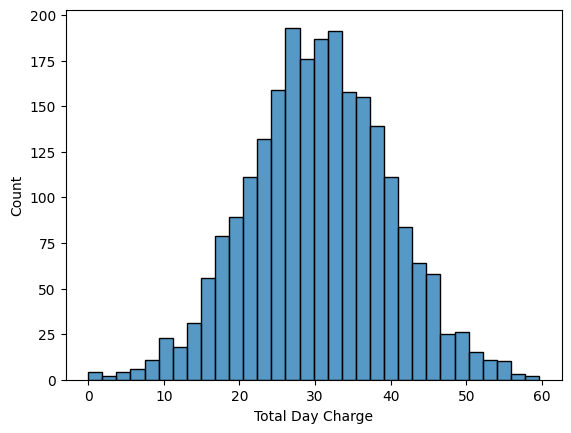

In [21]:
sns.histplot(data=train_df, x="total day charge")
plt.xlabel("Total Day Charge")

## Minimum and Maximum of account length, And its Distriution 

In [22]:
train_df["account length"].min(), train_df["account length"].max()

(1, 243)

Text(0.5, 0, 'Account Length')

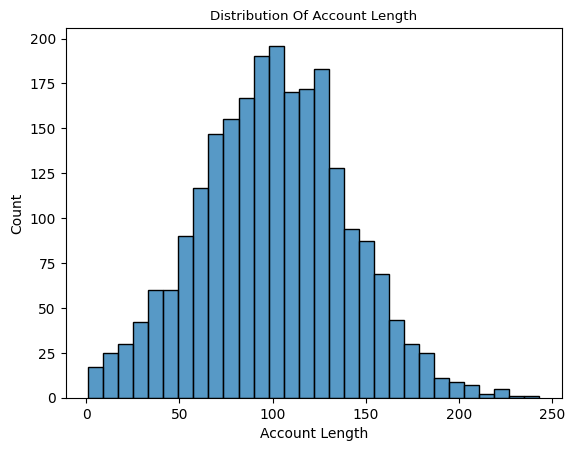

In [23]:
sns.histplot(train_df["account length"])
sns.set_context('paper', font_scale = 1)
plt.title("Distribution Of Account Length")
plt.xlabel("Account Length")

## Visulizing the counts of users from different states 

Text(0.5, 1.0, 'Visulizing the counts of users from different states')

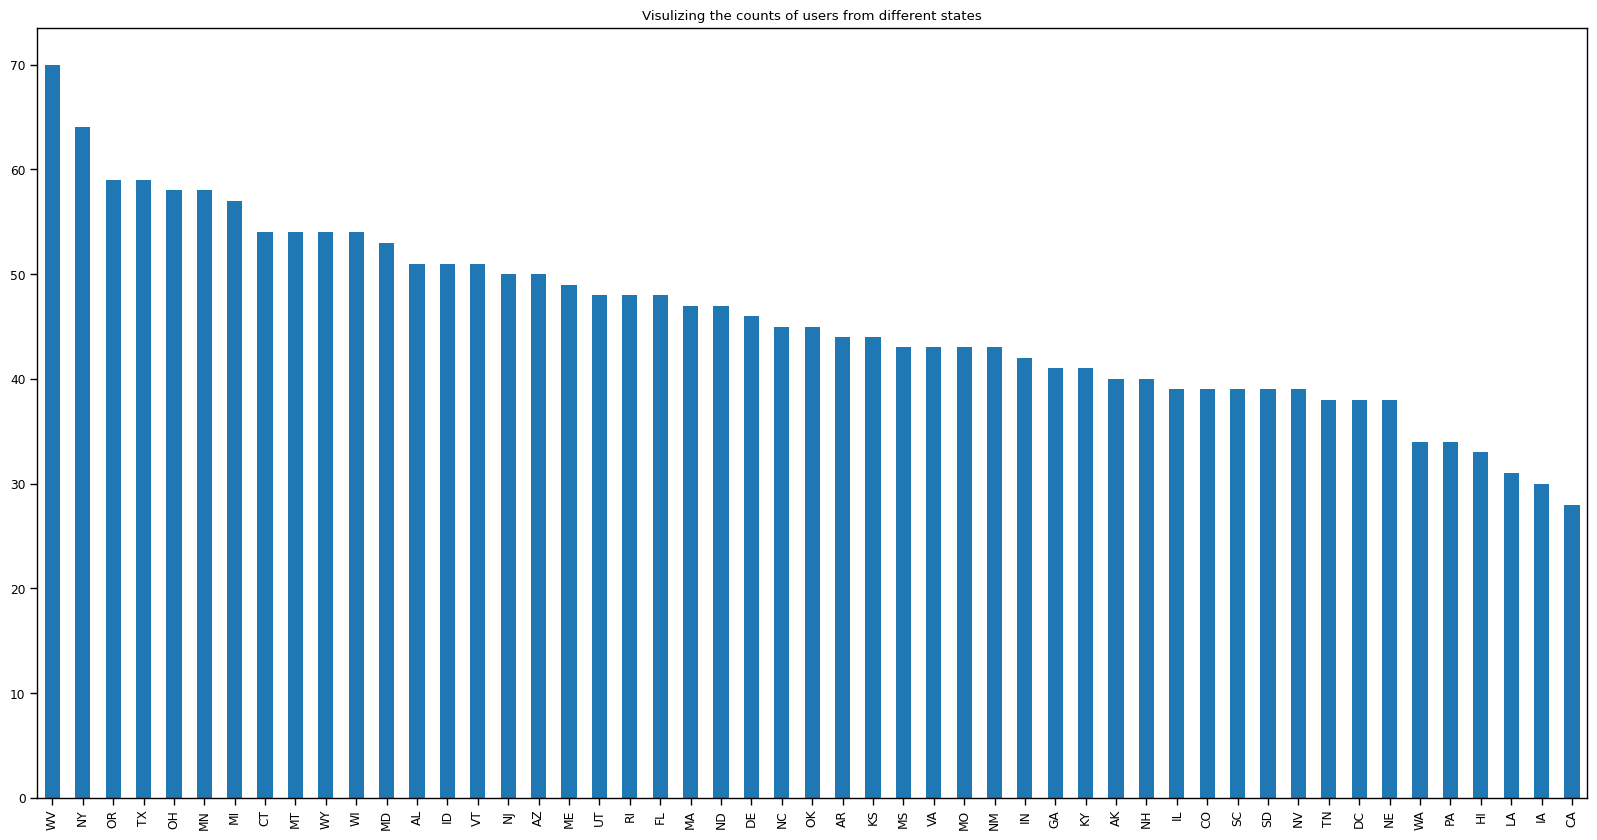

In [24]:
train_df["state"].value_counts().plot(kind="bar", figsize=(20, 10))
sns.set_color_codes('deep')
plt.title("Visulizing the counts of users from different states")

<br><br>

###  Column transformer 

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for me. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

In each case, briefly explain your rationale with 1-2 sentences. But for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [25]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [26]:
X_train.head(50)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,204.7,77,17.40,256.6,101,11.55,5.7,4,1.54,1
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,142.3,76,12.10,91.2,86,4.10,10.9,5,2.94,2
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,89.7,103,7.62,220.0,91,9.90,15.6,4,4.21,2
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,163.1,105,13.86,282.5,100,12.71,10.0,3,2.70,1
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,261.5,95,22.23,241.6,104,10.87,11.4,9,3.08,2
733,NM,85,408,338-9210,no,yes,37,229.6,123,39.03,132.3,90,11.25,211.9,76,9.54,9.5,8,2.57,2
28,MO,20,415,353-2630,no,no,0,190.0,109,32.30,258.2,84,21.95,181.5,102,8.17,6.3,6,1.70,0
110,MI,120,408,409-3786,no,no,0,165.0,100,28.05,317.2,83,26.96,119.2,86,5.36,8.3,8,2.24,1
2028,SD,93,510,408-4836,no,no,0,328.1,106,55.78,151.7,89,12.89,303.5,114,13.66,8.7,3,2.35,1
2670,WY,116,510,392-2733,no,yes,12,221.0,108,37.57,151.0,118,12.84,179.0,80,8.06,9.0,6,2.43,2


In [27]:
# Visulizing all the columns from the data frame

train_df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [28]:
# Ther is no null values in the train_df data frame so there is no need to perform simple imputer further in the process

train_df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [29]:
# Getting all the numeric columns from the train_df data frame

list(train_df.select_dtypes([np.number]).columns.values)

['account length',
 'area code',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'churn']

In [30]:
# Let's divide the columns into different features that we can apply further in the make_column_transformation function

numeric_features = [
    "account length",
    'number vmail messages',
    'total day minutes',
    'total day calls',
    'total day charge',
    'total eve minutes',
    'total eve calls',
    'total eve charge',
    'total night minutes',
    'total night calls',
    'total night charge',
    'total intl minutes',
    'total intl calls',
    'total intl charge',
    'customer service calls'
]

categorical_features = [
    "state",
    "area code"
]

binary_feaures = [
    "international plan",
    "voice mail plan"
]

drop_features = [
    "phone number"
]

passthrough_features = []

In [31]:
#  Applying make_column_transformer function

column_transformer = make_column_transformer(
    (
        StandardScaler(), 
        numeric_features
    ), # Applying StandardScaler() function on numeric_features
    
    (
        OneHotEncoder(sparse=False, handle_unknown="ignore"),
        categorical_features  
    ), # Applying OHE on categoical_features
    
    (
        OneHotEncoder(drop="if_binary", dtype=int),
        binary_feaures
    ), # Applying OHE on categoical_features and droping the binary features
    
    ("drop", drop_features),
    ("passthrough", passthrough_features)
)

In [32]:
column_transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['account length', 'number vmail messages',
                                  'total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'customer service calls']),
                                ('onehotencoder-1',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['state', 'area code']),
                                ('onehotencoder-2',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['international plan', 'voice mail plan']),
                                ('drop', 'drop', ['phone number']),
                                ('passthrough', 'passthrough', [])])

<br><br>

### Visualizing the transformed data 

Fitting and transforming the `ColumnTransformer` on my training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array).  

In [33]:
X_transformed = column_transformer.fit_transform(X_train)

In [34]:
column_names = (
    numeric_features
    + column_transformer.named_transformers_["onehotencoder-1"].get_feature_names_out().tolist()
    + column_transformer.named_transformers_["onehotencoder-2"].get_feature_names_out().tolist()
)

In [35]:
column_names

['account length',
 'number vmail messages',
 'total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'customer service calls',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'ar

<br><br>

In [36]:
pd.DataFrame(data=X_transformed, columns=column_names)

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510,international plan_yes,voice mail plan_yes
0,-0.767893,-0.587624,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,0.052115,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.843585,-0.587624,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,-0.720990,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.544113,1.900976,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,-0.463288,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.165650,-0.587624,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,0.000574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.115188,-0.587624,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,0.206736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.645037,-0.587624,0.329045,1.259175,0.328771,0.898602,0.612316,0.897957,1.652771,0.206736,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2329,-0.767893,1.608200,-0.664820,-1.414346,-0.664665,-0.618094,-0.398570,-0.618157,-1.440956,-1.648715,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2330,0.619806,-0.587624,0.048489,-1.810423,0.048322,-1.216842,1.067214,-1.217606,-0.582024,-0.205587,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2331,1.477656,-0.587624,0.173180,0.219472,0.173445,0.890672,2.381365,0.890960,0.801701,0.309816,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### area code feature

The original dataset had a feature called `area code`. Let's assume i had encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?
2. What were the possible values of `area code`? 
3. What new feature(s) were created to replace `area code`? 

In [37]:
print("1 Because there are only 3 unique values in the area code column it is also coategircal features instead of numeric features")
print("2 There are 3 values availabe in the area code column : ", train_df["area code"].unique())
print('3 area code_408,', 'area code_415,', 'area code_510',)

1 Because there are only 3 unique values in the area code column it is also coategircal features instead of numeric features
2 There are 3 values availabe in the area code column :  [415 510 408]
3 area code_408, area code_415, area code_510


<br><br>

### Dummy classifier

**tasks:**

Creating a `DummyClassifier`. Reporting the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly commenting the results, including any warnings the code produces.

In [38]:
dummy = DummyClassifier()
scoring = ["accuracy", "precision", "recall", "f1"]
dummy_pipe = make_pipeline(column_transformer, dummy)
pd.DataFrame(
    cross_validate(
        dummy_pipe, 
        X_train, 
        y_train, 
        scoring=scoring, 
        return_train_score=True)
)

C:\Users\vasup\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vasup\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vasup\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vasup\AppData\Local

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.025620,0.125075,0.850107,0.850482,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010110,0.014640,0.850107,0.850482,0.0,0.0,0.0,0.0,0.0,0.0
2,0.020006,0.010072,0.850107,0.850482,0.0,0.0,0.0,0.0,0.0,0.0
3,0.015086,0.010041,0.851931,0.850027,0.0,0.0,0.0,0.0,0.0,0.0
4,0.015128,0.010048,0.849785,0.850562,0.0,0.0,0.0,0.0,0.0,0.0


>There is no predicted results an its completely correct because DummyClassifier() classifies most prior value and in this output it classifies False as there are more False class than True

<br><br>

### Logistic regression

**tasks:**

1. Train and score a logistic regression classifier on the dataset. 
2. Report the same metrics as in the previous part.
3. Are you satisfied with the results? Use your `DummyClassifier` results as a reference point. Discuss in a few sentences. 

In [39]:
Logistic = LogisticRegression()
Logistic_pipe = make_pipeline(column_transformer, Logistic)
results = cross_validate(
    Logistic_pipe, 
    X_train, 
    y_train, 
    scoring=scoring, 
    cv=5, 
    return_train_score=True
)

In [40]:
pd.DataFrame(results)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.289924,0.040098,0.869379,0.864416,0.666667,0.630000,0.257143,0.225806,0.371134,0.332454
1,0.054874,0.009911,0.852248,0.868167,0.520000,0.654206,0.185714,0.250896,0.273684,0.362694
2,0.060156,0.009801,0.850107,0.867095,0.500000,0.639640,0.171429,0.254480,0.255319,0.364103
3,0.060063,0.010039,0.869099,0.863953,0.642857,0.620370,0.260870,0.239286,0.371134,0.345361
4,0.059986,0.009687,0.839056,0.868773,0.413793,0.651786,0.171429,0.261649,0.242424,0.373402


>Well we can see that we get the satisfactory result than the DummyClassifer(), In ths outcome we can see that there is high precision in compare to recall which says that an algorithm returns more relevant results than irrelevant ones which is positive outcome

<br><br>

###  Logistic regression with `class_weight`

**tasks:**

1. Set the `class_weight` parameter of my logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do i prefer this model to the one in the previous part? Let's see that further and i'll discuss my results in a few sentences.

In [41]:
Logistic = LogisticRegression(class_weight="balanced")
Logistic_pipe = make_pipeline(column_transformer, Logistic)
results = cross_validate(
    Logistic_pipe,
    X_train,
    y_train, 
    scoring=scoring,
    cv=5,
    return_train_score=True
)

In [42]:
pd.DataFrame(results)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.085674,0.018928,0.785867,0.769561,0.380952,0.369151,0.685714,0.763441,0.489796,0.497664
1,0.070042,0.010075,0.768737,0.771168,0.366197,0.372852,0.742857,0.777778,0.490566,0.504065
2,0.065017,0.009936,0.764454,0.774384,0.348485,0.378007,0.657143,0.788530,0.455446,0.511034
3,0.060313,0.010296,0.751073,0.779325,0.340136,0.385017,0.724638,0.789286,0.462963,0.517564
4,0.070011,0.010142,0.733906,0.786824,0.320000,0.395797,0.685714,0.810036,0.436364,0.531765


>Here the outcome is more balanced in training and testing score and it also improved our model F1 score in comapre to the previous model, According to me, By seeing all this outcome i am more satisfied with this model

<br><br>

## Hyperparameter optimization

Now let's tune the hyperparameters of our LogisticRegression using GridSearchCV to maximize cross-validation f1 score.

**tasks:**

Jointly optimize C (choose some reasonable values) and class_weight (None vs. 'balanced') with GridSearchCV and scoring="f1".
What values of C and class_weight are chosen and what is the best cross-validation f1 score?

In [43]:
param_grid = {
    "logisticregression__C" : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    "logisticregression__class_weight" : [None, "balanced"]
}

Logistic_pipe = make_pipeline(
    column_transformer, 
    LogisticRegression(max_iter=1000)
)

Grid_search_cv = GridSearchCV(
    Logistic_pipe,
    param_grid,
    scoring="f1",
    cv=5,
    return_train_score=True
)

Grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['account '
                                                                          'length',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
                                                                          'day '
                                                                          'calls',
                                                                          'total '
                                                                          'day '
                                                                          'charge',
                                                                          'total '
                                                                          'eve '
                                                                          'minutes',
                                                                          'total '
                                                                          'eve '
                                                                          'calls',
                                                                          'total '
                                                                          'eve '
                                                                          'charge',
                                                                          'total '
                                                                          'night '
                                                                          'minutes',
                                                                          'total '
                                                                          'night '
                                                                          'calls',
                                                                          '...
                                                                                       dtype=<class 'int'>),
                                                                         ['international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['phone '
                                                                          'number']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         [])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=

In [44]:
print("Best Parameter : ", Grid_search_cv.best_params_)
print("Best Score : ", Grid_search_cv.best_score_)

Best Parameter :  {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}
Best Score :  0.47873599874436196


### Test results

**tasks**

1. Evaluating the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 
3. Comment on the results.    

> Note that we are not doing it here but in real life, you would also plot confusion matrix, precision-recall curve, and ROC curve on validation data to examine errors and to choose a threshold which works for your operating point. 

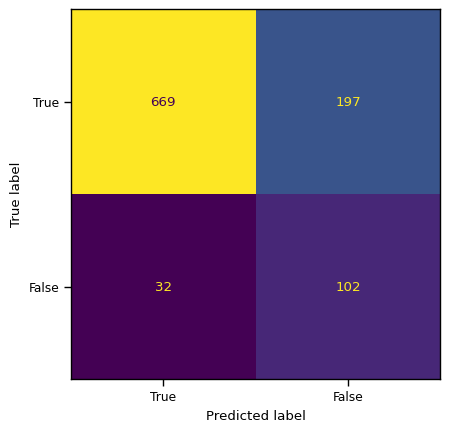

In [45]:
# Evaluating Confusion Matrix

Logistic_pipe = make_pipeline(column_transformer, LogisticRegression(C=0.1, class_weight="balanced"))
Logistic_pipe.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(
    Logistic_pipe, 
    X_test, 
    y_test, 
    colorbar=False, 
    display_labels=["True", "False"]
)


In [46]:
# Evaluating classification report
# Here 0 represents True and, 1 represents as false

print(classification_report(y_test, Logistic_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       866
           1       0.34      0.76      0.47       134

    accuracy                           0.77      1000
   macro avg       0.65      0.77      0.66      1000
weighted avg       0.87      0.77      0.80      1000



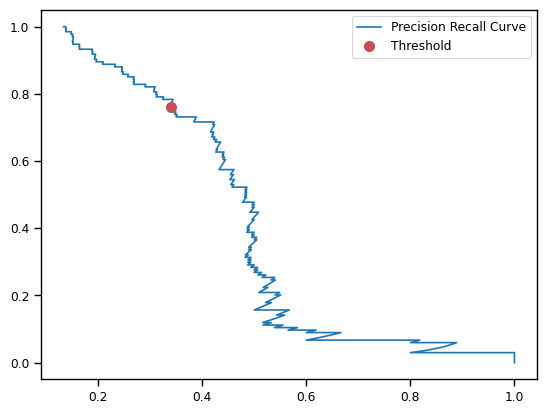

In [47]:
# Evaluating Precison recall curve 

precision, recall, Threshold = precision_recall_curve(
    y_test,
    Logistic_pipe.predict_proba(X_test)[:,1]
)

plt.plot(
    precision,
    recall,
    label="Precision Recall Curve"
)

plt.plot(
    precision_score(y_test, Logistic_pipe.predict(X_test)),
    recall_score(y_test, Logistic_pipe.predict(X_test)),
    "ro",
    markersize=7,
    label="Threshold"
)

plt.legend(loc="best")

In [48]:
# Evaluating ROC curve with AUC.

print(
    "Average Precision Score of Logistic Regression: %.3f"% average_precision_score(y_test, 
                                                                                    Logistic_pipe.predict_proba(X_test)[:,1]))

Average Precision Score of Logistic Regression: 0.456


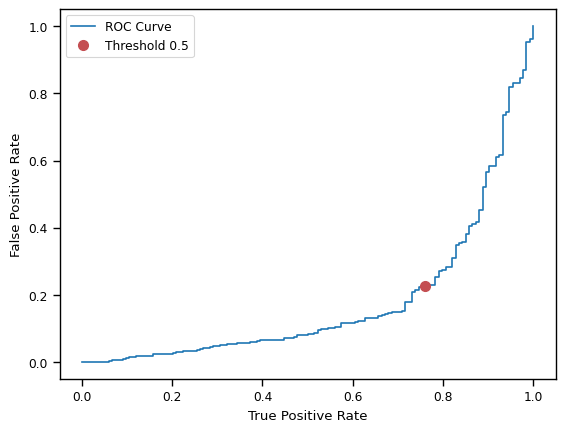

In [49]:
True_positive_rate, False_positive_rate, threshold = roc_curve(y_test,
                                                              Logistic_pipe.predict_proba(X_test)[:,1])
plt.plot(False_positive_rate, True_positive_rate , label="ROC Curve")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")

default_threshold = np.argmin(np.abs(threshold - 0.5))

plt.plot(False_positive_rate[default_threshold],
        True_positive_rate[default_threshold],
        "ro",
        markersize=7,
        label="Threshold 0.5"
)
plt.legend(loc="best")


In [50]:
Area_under_ROC_curve = roc_auc_score(y_test,
                                     Logistic_pipe.predict_proba(X_test)[:,1])
print("Area Under The ROC Curve : %.03f"% Area_under_ROC_curve)

Area Under The ROC Curve : 0.823


<br><br><br><br>

### Regression metrics <a name="3"></a>
<hr> 


For this i'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [51]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### Data spitting and exploration 

**tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do i need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [52]:
# Spliting the dataset into train and test

In [53]:
train_df, test_df = train_test_split(housing_df, test_size=0.20)

In [54]:
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
10671,10.3893,18.0,6.750000,0.972222,316.0,2.925926,33.62,-117.85,5.00001
3419,2.6652,22.0,4.152302,0.956316,3134.0,3.700118,34.28,-118.40,1.64800
19362,3.3125,9.0,16.541284,3.116208,594.0,1.816514,38.70,-123.49,2.95400
9498,2.3750,20.0,5.818640,1.312343,1745.0,2.197733,39.17,-123.73,1.58800
1494,4.1250,19.0,5.373737,1.030303,1317.0,2.217172,37.94,-122.02,2.67100
...,...,...,...,...,...,...,...,...,...
12859,0.9338,35.0,5.301887,1.641509,240.0,2.264151,38.67,-121.39,1.12500
9632,2.7316,16.0,5.226415,1.080189,1135.0,2.676887,37.25,-121.01,0.97500
3636,4.0057,37.0,5.489270,1.034335,987.0,4.236052,34.24,-118.43,1.72700
10248,6.9612,24.0,8.307054,1.049793,820.0,3.402490,33.89,-117.86,2.74500


In [55]:
columns = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude"]

column_transformer = make_column_transformer(
    (StandardScaler(),columns)
)

In [56]:
column_transformer

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                                  'Population', 'AveOccup', 'Latitude',
                                  'Longitude'])])

In [57]:
X_train, y_train = train_df.drop(columns=["MedHouseVal"]), train_df["MedHouseVal"]
X_test, y_test = test_df.drop(columns=["MedHouseVal"]), test_df["MedHouseVal"]

In [58]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
10671,10.3893,18.0,6.750000,0.972222,316.0,2.925926,33.62,-117.85
3419,2.6652,22.0,4.152302,0.956316,3134.0,3.700118,34.28,-118.40
19362,3.3125,9.0,16.541284,3.116208,594.0,1.816514,38.70,-123.49
9498,2.3750,20.0,5.818640,1.312343,1745.0,2.197733,39.17,-123.73
1494,4.1250,19.0,5.373737,1.030303,1317.0,2.217172,37.94,-122.02
...,...,...,...,...,...,...,...,...
12859,0.9338,35.0,5.301887,1.641509,240.0,2.264151,38.67,-121.39
9632,2.7316,16.0,5.226415,1.080189,1135.0,2.676887,37.25,-121.01
3636,4.0057,37.0,5.489270,1.034335,987.0,4.236052,34.24,-118.43
10248,6.9612,24.0,8.307054,1.049793,820.0,3.402490,33.89,-117.86


In [59]:
pd.DataFrame(y_train)

,MedHouseVal
10671,5.00001
3419,1.64800
19362,2.95400
9498,1.58800
1494,2.67100
...,...
12859,1.12500
9632,0.97500
3636,1.72700
10248,2.74500


###  Baseline: DummyRegressor 

**tasks:**

1. Carry out cross-validation using `DummyRegressor` with default scoring. 
2. What metric is used for scoring by default? 

In [60]:
Dummy = DummyRegressor()
Dummy_pipe = make_pipeline(column_transformer, Dummy)
score = cross_validate(Dummy_pipe, X_train, y_train)

In [61]:
pd.DataFrame(score)

,fit_time,score_time,test_score
0,0.008001,0.003036,-0.000180
1,0.009543,0.005006,-0.000940
2,0.010042,0.000000,-0.000097
3,0.005008,0.005239,-0.001205
4,0.016178,0.003567,-0.000642


<br><br>

### Different regressors

In this i am going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if i don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Using a pipeline with the model as an estimator if i am applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [62]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [63]:
result__dict = {}

for i in models:
    model = make_pipeline(column_transformer, models[i])
    score = cross_validate(model, X_train, y_train, scoring= score_types_reg)
    
    for s in score:
        score[s] = score[s].mean()
        result__dict[i] = score

In [64]:
result = pd.DataFrame(result__dict)

In [65]:
result

,Ridge,Random Forest
fit_time,0.071001,9.764916
score_time,0.010498,0.130183
test_neg_mean_squared_error,-0.529606,-0.259268
test_neg_root_mean_squared_error,-0.727429,-0.509102
test_neg_mean_absolute_error,-0.533816,-0.332820
test_r2,0.602939,0.805336
test_mape_scorer,-31.876539,-18.683121


<br><br>

### Hyperparameter optimization 

**tasks:**

1. Carrying out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choosing the metric of my choice for hyperparameter optimization. 
2. I am getting better scores compared to the default values? Let's check that.

In [66]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

pipe = make_pipeline(column_transformer, Ridge())
Random_search_cv = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=1000)
Random_search_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['MedInc',
                                                                                'HouseAge',
                                                                                'AveRooms',
                                                                                'AveBedrms',
                                                                                'Population',
                                                                                'AveOccup',
                                                                                'Latitude',
                                                                                'Longitude'])])),
                                             ('ridge', Ridge())]),
                   n_iter=1000,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000206D1343010>})

In [67]:
# Seeing best params 

print(" Best Params : ", Random_search_cv.best_params_)
print(" Best Score : ", Random_search_cv.best_score_)

 Best Params :  {'ridge__alpha': 13.652924013509143}
 Best Score :  0.6029561969605339


In [68]:
# Kepping defult params (Alpha=1.0)

default_params = make_pipeline(column_transformer, Ridge())

score = cross_validate(default_params, X_train, y_train, return_train_score=True)
pd.DataFrame(score)

,fit_time,score_time,test_score,train_score
0,0.029832,0.000000,0.616424,0.601828
1,0.022866,0.007094,0.588187,0.607967
2,0.018735,0.000000,0.596407,0.606647
3,0.014977,0.000000,0.611649,0.602784
4,0.013112,0.006525,0.602026,0.605114


In [69]:
score_mean = {}

for loop in score:
    score_mean[loop] = score[loop].mean() 

In [70]:
pd.DataFrame([score_mean])

,fit_time,score_time,test_score,train_score
0,0.019904,0.002724,0.602939,0.604868


<br><br>

### Test results

**tasks:**

1. Try the best model on the test set.
2. Briefly comment on the results.

In [73]:
Random_search_cv.best_estimator_.score(X_test, y_test)

0.5836612061363669

<br><br>

### Model interpretation  

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**tasks:**

1. Visualizing coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. If i had attempted 3.4, use the `Ridge` model with best hyperparameters. Otherwise use the `Ridge` model with default hyperparameters. 
2. Increasing which feature values would result in higher housing price? 

<br><br>

In [71]:
best_ridge = Random_search_cv.best_estimator_.get_params()["ridge"]

data = {"Features":columns,"Coeffecients":best_ridge.coef_}
pd.DataFrame(data)

,Features,Coeffecients
0,MedInc,0.818620
1,HouseAge,0.126092
2,AveRooms,-0.248583
3,AveBedrms,0.293334
4,Population,-0.002874
5,AveOccup,-0.039928
6,Latitude,-0.897918
7,Longitude,-0.864652
